# Setup

### Imports

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
import json

### Loading CSV into DataFrames

In [2]:
df_categories = pd.read_csv('steam_data/categories.csv')
df_games = pd.read_csv('steam_data/games.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")
df_genres = pd.read_csv('steam_data/genres.csv')
df_reviews = pd.read_csv('steam_data/reviews.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")
df_tags = pd.read_csv('steam_data/tags.csv')
df_steamspy_insights = pd.read_csv('steam_data/steamspy_insights.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")

C:\Users\Jonas\AppData\Local\Temp\ipykernel_2344\574882810.py:4: DtypeWarning: Columns (1,3,4,5,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv('steam_data/reviews.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")


### Pre_Processing

Converting json-like object in price_overview column into separate column for easier usage

In [3]:
def extract_price_info(price_str):
    try:
        data = json.loads(price_str)
    except (TypeError, json.JSONDecodeError):
        return pd.Series({
            'final': None,
            'initial': None,
            'currency': None,
            'final_formatted': None,
            'discount_percent': None,
            'initial_formatted': None,
        })
    return pd.Series({
        'final': data.get('final'),
        'initial': data.get('initial'),
        'currency': data.get('currency'),
        'final_formatted': data.get('final_formatted'),
        'discount_percent': data.get('discount_percent'),
        'initial_formatted': data.get('initial_formatted'),
    })

Inserting new column into games table

In [4]:
price_details = df_games['price_overview'].apply(extract_price_info)
df_games = pd.concat([df_games, price_details], axis=1)

# to remvoe the original 'price_overview' column
df_games = df_games.drop(columns=['price_overview'])

Cleaning the 'languages' column from <\br> <\strong> and * signs

In [5]:
# <strong> tags
df_games['languages'] = df_games['languages'].str.replace(r'</?strong>', '', regex=True)

# <br> tags (covers <br>, <br/>, or <br />)
df_games['languages'] = df_games['languages'].str.replace(r'</?br\s*/?>', '', regex=True)


# asterisks (*)
df_games['languages'] = df_games['languages'].str.replace('*', '', regex=False)

# to remove space before and the phrase "with full audio support"
df_games['languages'] = df_games['languages'].str.replace(r'\s*with full audio support', '', regex=True)

Creating polished CSV

In [6]:
df_games.to_csv('steam_data/games_cleaned.csv', index=False)

# EDA

### Top 20 most categorized games

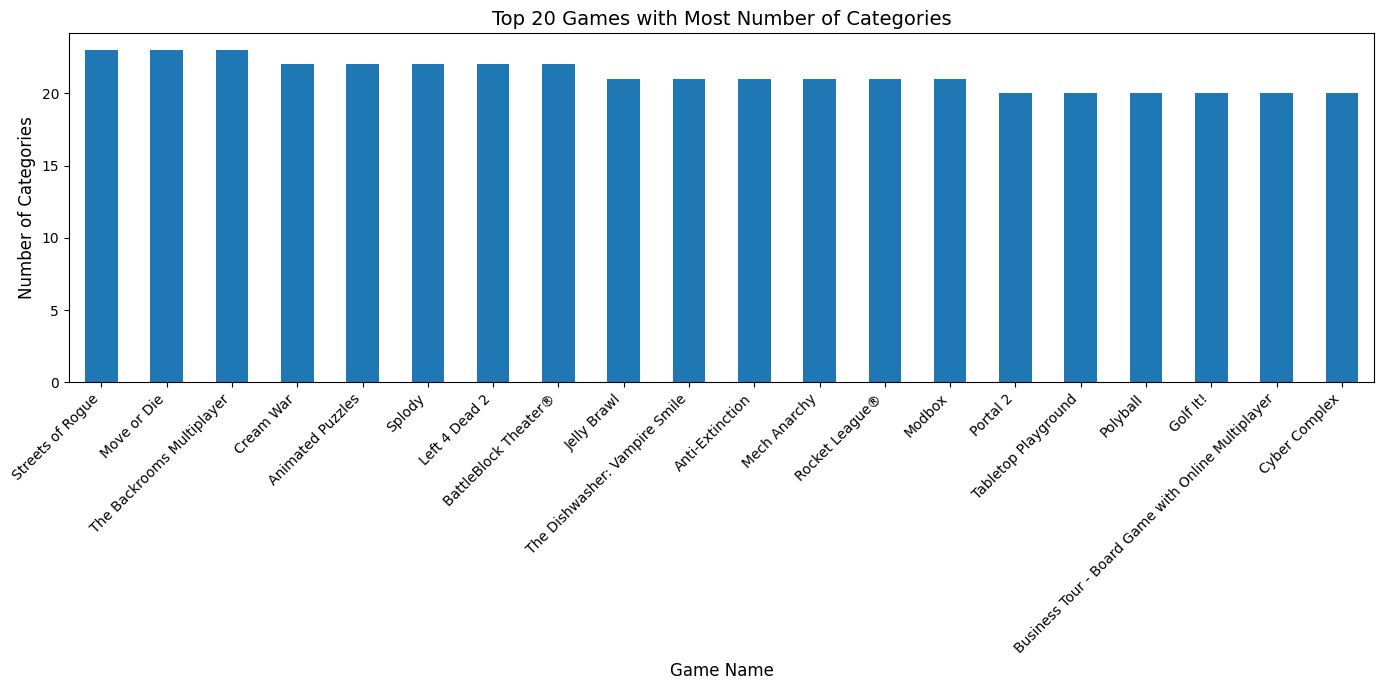

In [7]:
# Count the number of categories for each game
category_count_df = df_categories.groupby('app_id').size().reset_index(name='category_count')

# Merge with the games dataframe to get the game names
category_count_df = category_count_df.merge(df_games[['app_id', 'name']], on='app_id')

# Define a var for the top 20 games with the most categories
top_20_category_count_df = category_count_df.sort_values(by='category_count', ascending=False).head(20)

# Plot the dataset
plt.figure(figsize=(14, 7))
top_20_category_count_df.plot(x='name', y='category_count', kind='bar', legend=False, ax=plt.gca())
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel('Game Name', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('Top 20 Games with Most Number of Categories', fontsize=14)
plt.tight_layout()
plt.show()


### 10 most popular game genres

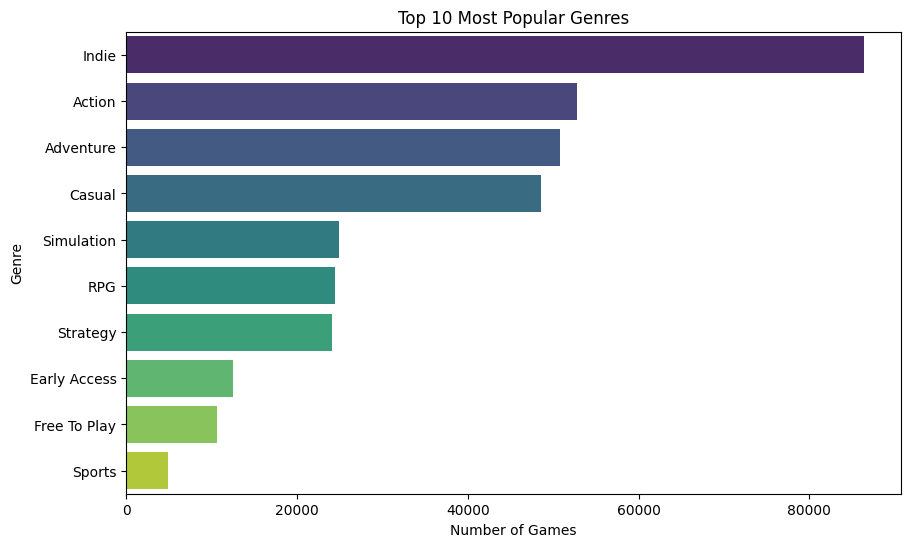

In [8]:
# Count the number of games in each genre
genre_counts = df_genres['genre'].value_counts().head(10)

# Plot the top 10 genres
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis', hue=genre_counts.index, legend=False)
plt.title('Top 10 Most Popular Genres')
plt.xlabel('Number of Games')
plt.ylabel('Genre')
plt.show()

### Looking at the amount of indie games on steam

In [9]:
# Count the number of indie games
indie_games_count = df_genres[df_genres['genre'] == 'Indie'].shape[0]

# Count the total number of games
total_games_count = df_genres.shape[0]

# Calculate the number of non-indie games
non_indie_games_count = total_games_count - indie_games_count

print(f"Number of Indie games: {indie_games_count}")
print(f"Number of Non-Indie games: {non_indie_games_count}")
print(f"Total number of games: {total_games_count}")

print(total_games_count/indie_games_count)

Number of Indie games: 86425
Number of Non-Indie games: 266914
Total number of games: 353339
4.0883887763957185


### Percentage of games released that are indie games by year

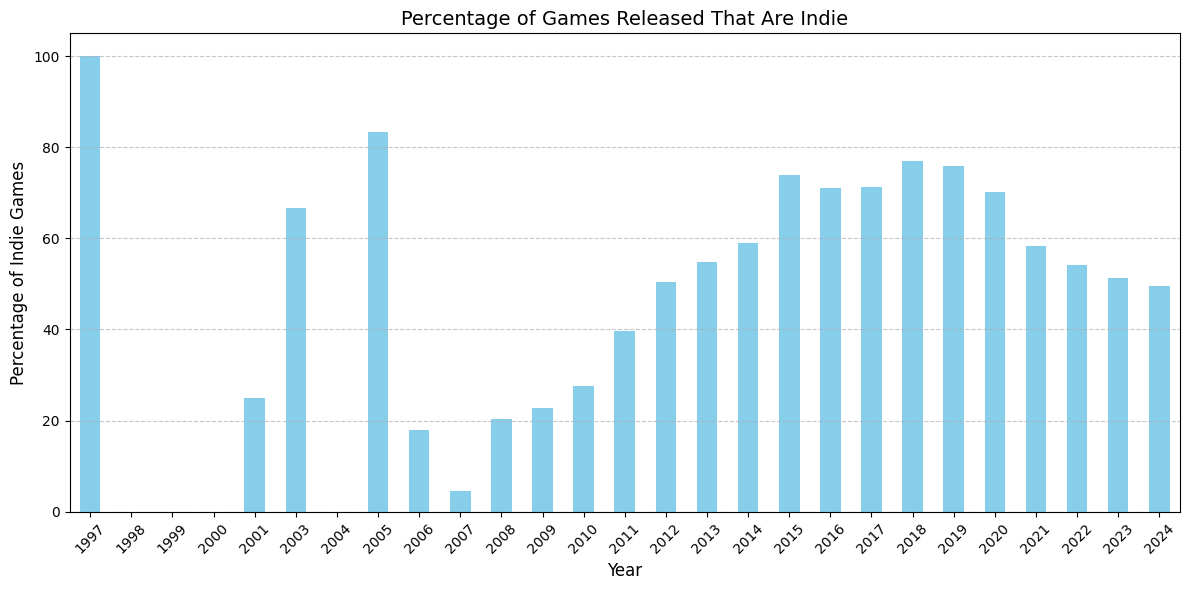

In [27]:
# Extract the release year from the release_date column
df_games['release_year'] = pd.to_datetime(df_games['release_date'], errors='coerce').dt.year

# Merge df_games with df_genres to get the genre information
df_games_genres = df_games.merge(df_genres, on='app_id')

# Calculate the number of indie games released each year
indie_games_per_year = df_games_genres[df_games_genres['genre'] == 'Indie'].groupby('release_year').size()

# Calculate the total number of games released each year
total_games_per_year = df_games.groupby('release_year').size()

# Calculate the ratio of indie games to total games released each year
indie_ratio_per_year = (indie_games_per_year / total_games_per_year) * 100

# Plot the ratio of indie games released over time as a bar plot
plt.figure(figsize=(12, 6))
indie_ratio_per_year.plot(kind='bar', color='skyblue')
plt.title('Percentage of Games Released That Are Indie', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Indie Games', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=range(len(indie_ratio_per_year.index)), labels=indie_ratio_per_year.index.astype(int), rotation=45)
plt.tight_layout()
plt.show()

### Number of indie games released by year

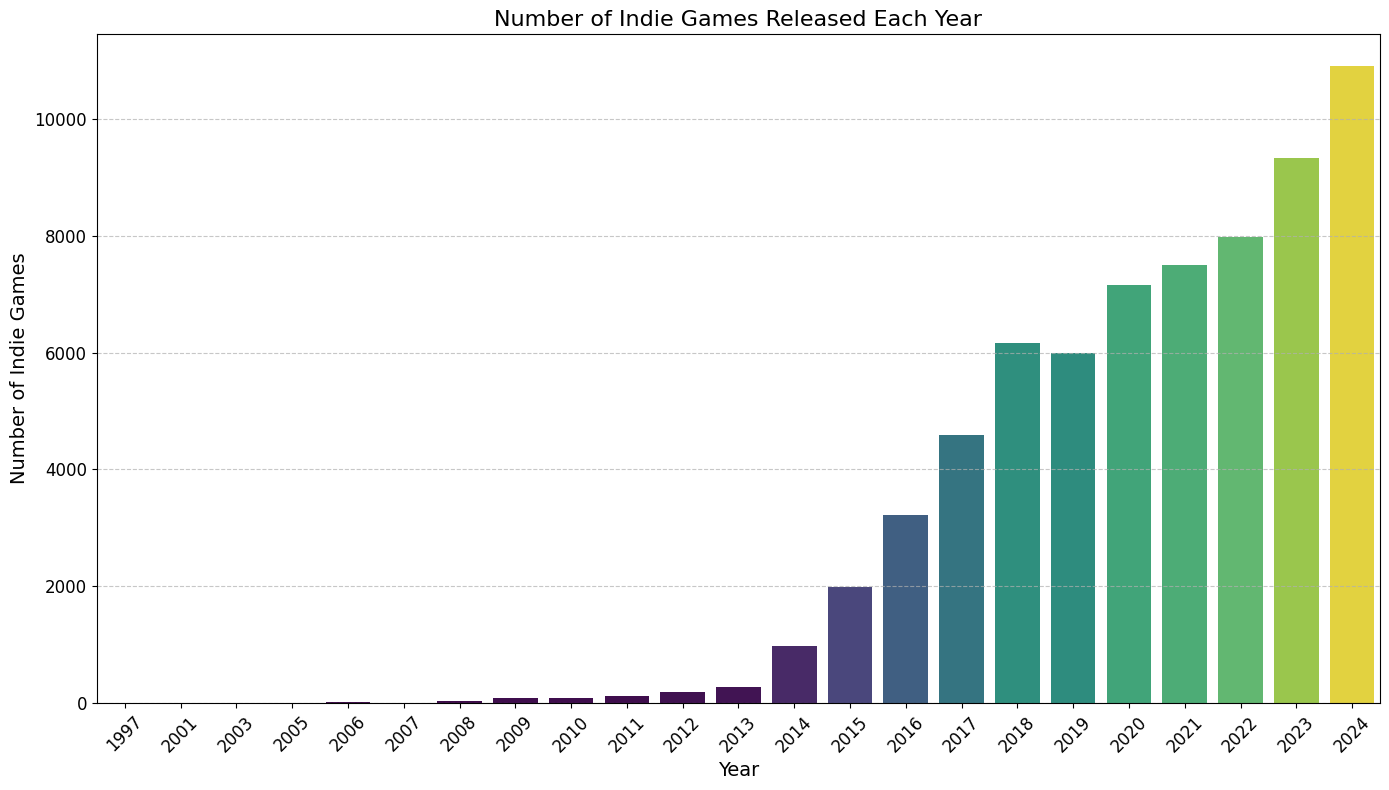

In [29]:
# Merge df_genres with df_games to get the genre and release year information together
df_games_genres = df_games.merge(df_genres, on='app_id')

# Filter the merged dataframe to include only indie games
indie_games = df_games_genres[df_games_genres['genre'] == 'Indie']

# Group by the release year and count the number of indie games released each year
indie_games_per_year = indie_games.groupby('release_year').size()

# Plot the number of indie games released each year as a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x=indie_games_per_year.index.astype(int), y=indie_games_per_year.values, palette='viridis', hue=indie_games_per_year.values, legend=False)

# Customize the plot
plt.title('Number of Indie Games Released Each Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Indie Games', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

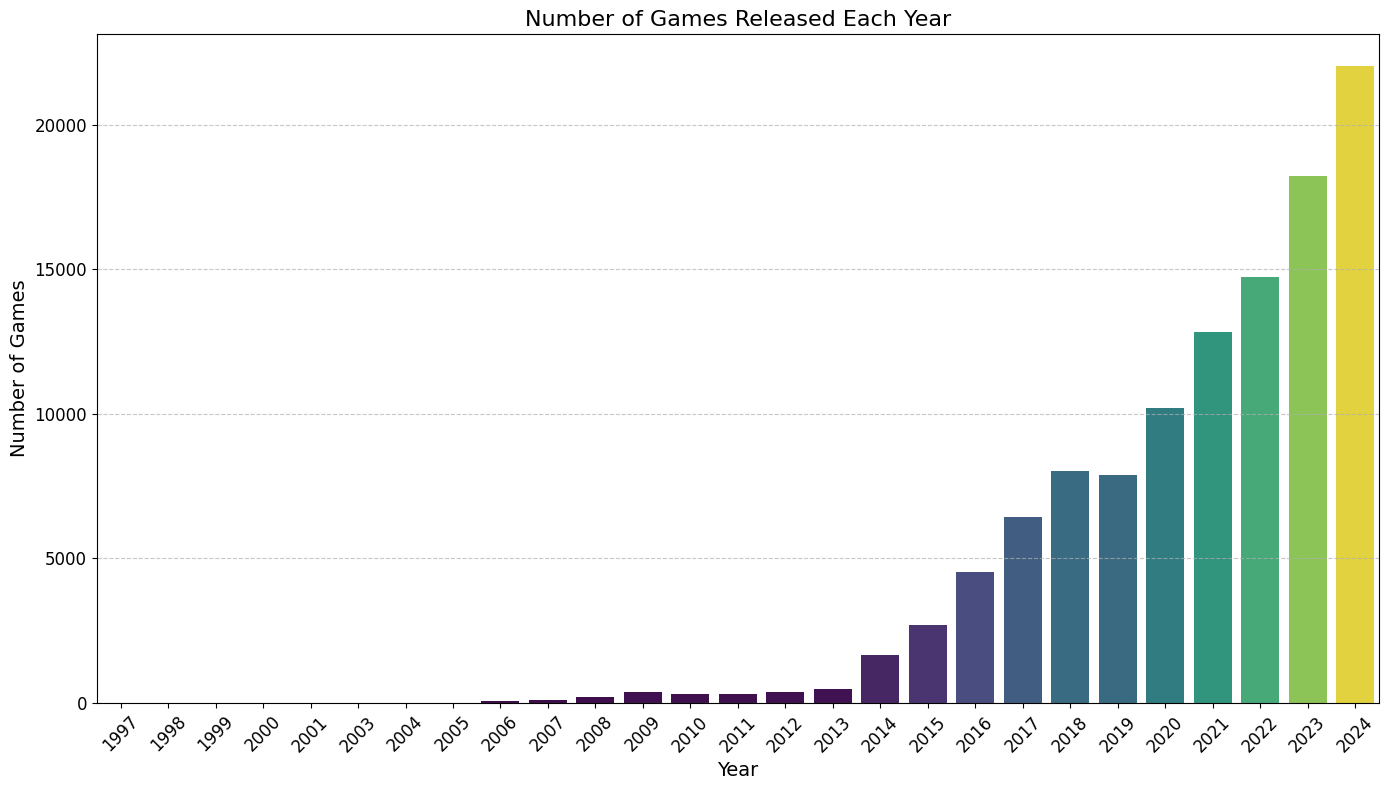

In [30]:
# Calculate the total number of games released each year
total_games_per_year = df_games.groupby('release_year').size()

# Plot the number of games released each year as a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x=total_games_per_year.index.astype(int), y=total_games_per_year.values, palette='viridis',hue=total_games_per_year.values, legend=False)

# Customize the plot
plt.title('Number of Games Released Each Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


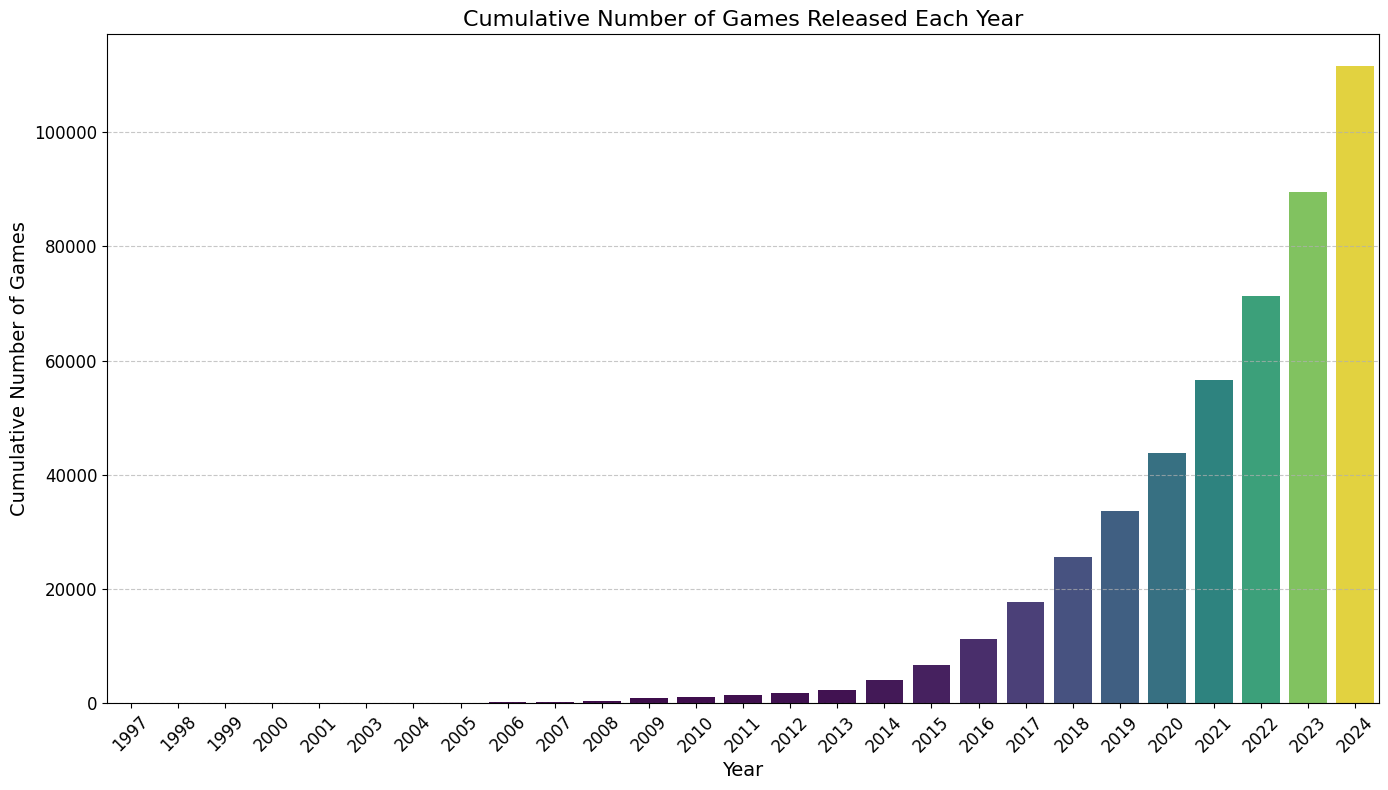

In [33]:
# Calculate the cumulative sum of games released every year
cumulative_games_per_year = total_games_per_year.cumsum()

# Create a dataframe from the cumulative sum series
df_cumulative_games_per_year = cumulative_games_per_year.reset_index()
df_cumulative_games_per_year.columns = ['release_year', 'cumulative_games']

# Convert release_year to integer
df_cumulative_games_per_year['release_year'] = df_cumulative_games_per_year['release_year'].astype(int)

# Plot the cumulative number of games released each year as a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='release_year', y='cumulative_games', data=df_cumulative_games_per_year, palette='viridis',hue="cumulative_games", legend=False)

# Customize the plot
plt.title('Cumulative Number of Games Released Each Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative Number of Games', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


### Overall yearly game releases compared to available steam games per year

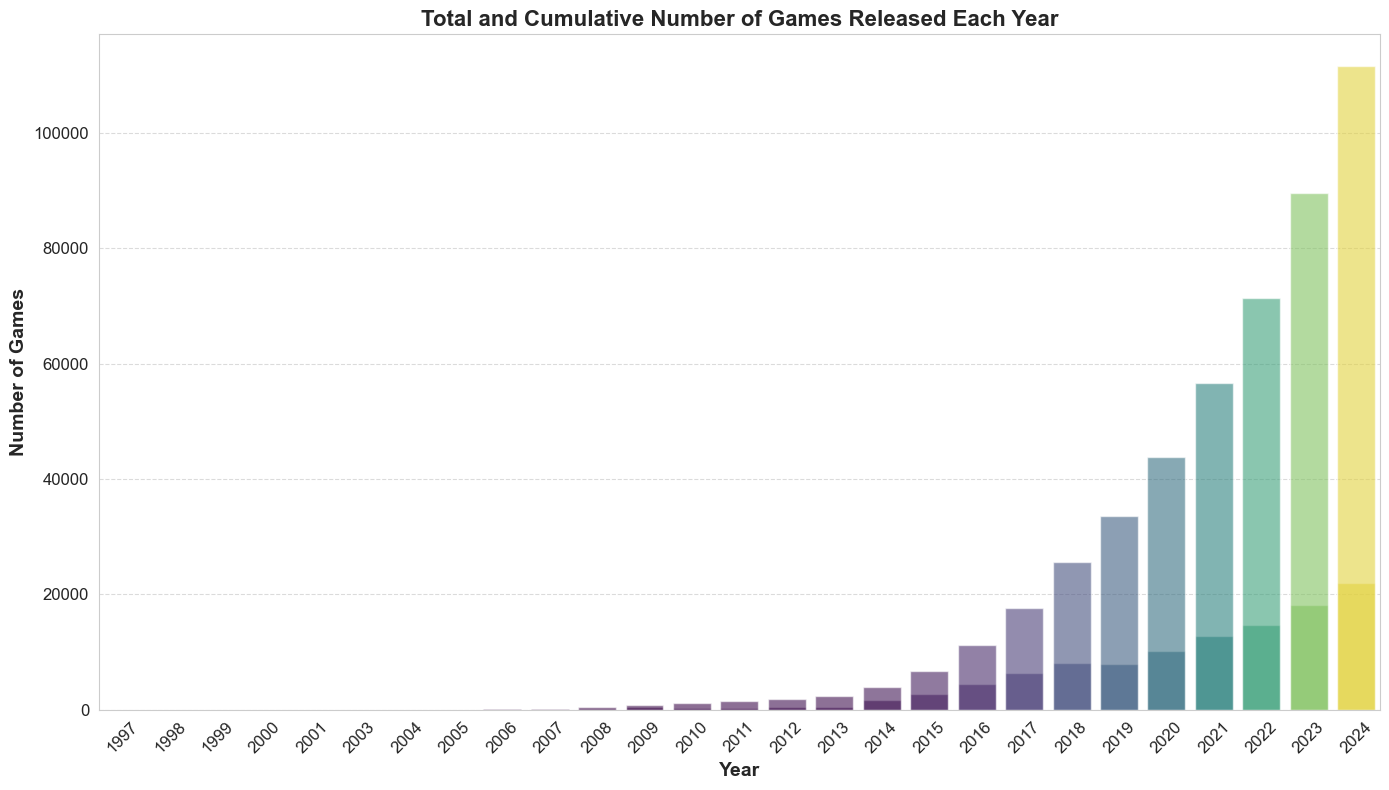

In [ ]:
# Plot the total games per year and cumulative games per year on the same graph
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

# Plot total games per year
sns.barplot(x=df_cumulative_games_per_year['release_year'], 
            y=total_games_per_year.values, 
            palette='viridis', 
            alpha=0.6, 
            label='Total Games Per Year', 
            hue=df_cumulative_games_per_year['cumulative_games'], 
            legend=False)

# Plot cumulative games per year
sns.barplot(x=df_cumulative_games_per_year['release_year'], 
            y=df_cumulative_games_per_year['cumulative_games'], 
            palette='viridis', 
            alpha=0.6, 
            label='Total Games Per Year', 
            hue=df_cumulative_games_per_year['cumulative_games'], 
            legend=False)

# Customize the plot
plt.title('Total and Cumulative Number of Games Released Each Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Games', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

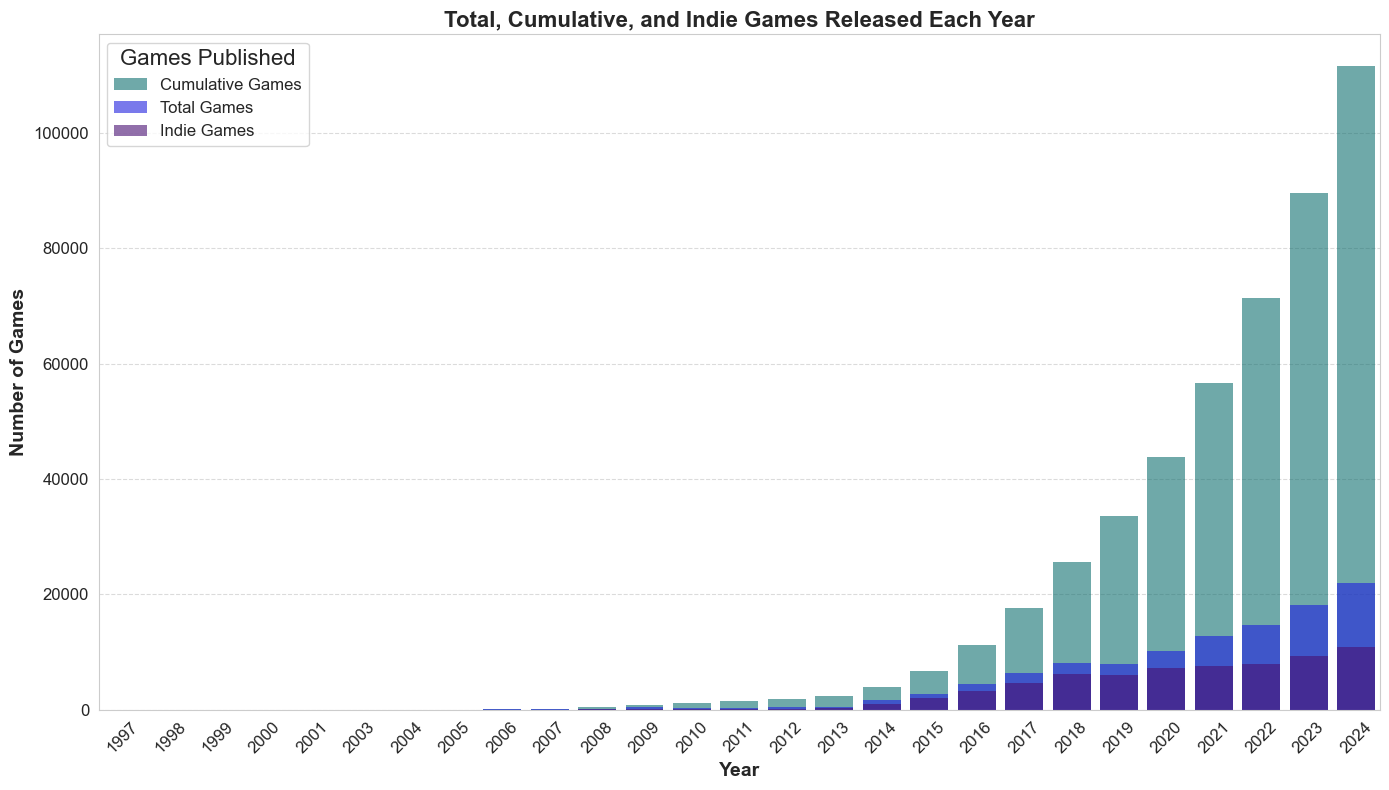

In [ ]:
# Plot the total games per year, cumulative games per year, and indie games per year on the same graph
plt.figure(figsize=(14, 8))

sns.set_style("whitegrid")

# Plot cumulative games per year
ax = sns.barplot(x=df_cumulative_games_per_year['release_year'], 
                 y=df_cumulative_games_per_year['cumulative_games'], 
                 color='teal', 
                 alpha=0.6, 
                 label='Games Published Yearly (Cumulative)',
                 linewidth=0)

# Plot total games per year
ax = sns.barplot(x=df_cumulative_games_per_year['release_year'], 
                 y=total_games_per_year.values, 
                 color='blue', 
                 alpha=0.6, 
                 label='Games Published Yearly',
                 linewidth=0)

# Plot indie games per year
ax = sns.barplot(x=indie_games_per_year.index.astype(int), 
                 y=indie_games_per_year.values, 
                 color='indigo', 
                 alpha=0.6, 
                 label='Indie Games Published Yearly',
                 linewidth=0)

# Customize the plot
plt.title('Total, Cumulative, and Indie Games Released Each Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Games', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(title="Games Published", fontsize='large', title_fontsize='16')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
